In [ ]:
artist_file = 'dataset.txt'


In [21]:
with open(artist_file,encoding='utf-8') as f: # The with keyword automatically closes the file when you are done
    print (f.read(1000))

with clytia he no longer was received <eos> than while he was a man of wealth believed <eos> balls , concerts , op'ras , tournaments , and plays <eos> expensive dresses , all engaging ways <eos> were used to captivate this lady fair <eos> while scarcely one around but in despair <eos> wife , widow , maid , his fond affection sought <eos> to gain him , ev'ry wily art was brought <eos> but all in vain :— by passion overpow'red <eos> the belle , whose conduct others would have soured <eos> to him appeared a goddess full of charms <eos> superior e'en to helen , in his arms <eos> from whence we may conclude , the beauteous dame <eos> was always deaf to fred'rick ' s ardent flame <eos>
our love is not a fading earthly flower <eos> its wing è d seed dropped down from paradise <eos> and , nursed by day and night , by sun and shower <eos> doth momently to fresher beauty rise <eos> to us the leafless autumn is not bare <eos> nor winter 's rattling boughs lack lusty green <eos> our summer hearts 

In [22]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
def plotWordFrequency(input):
    f = open(artist_file,'r',encoding='utf-8')
    words = [x for y in [l.split() for l in f.readlines()] for x in y]
    data = sorted([(w, words.count(w)) for w in set(words)], key = lambda x:x[1], reverse=True)[:40] 
    most_words = [x[0] for x in data]
    times_used = [int(x[1]) for x in data]
    plt.figure(figsize=(20,10))
    plt.bar(x=sorted(most_words), height=times_used, color = 'grey', edgecolor = 'black',  width=.5)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(rotation=0, fontsize=18)
    plt.xlabel('Most Common Words:', fontsize=18)
    plt.ylabel('Number of Occurences:', fontsize=18)
    plt.title('Most Commonly Used Words: %s' % (artist_file), fontsize=24)
    plt.show()

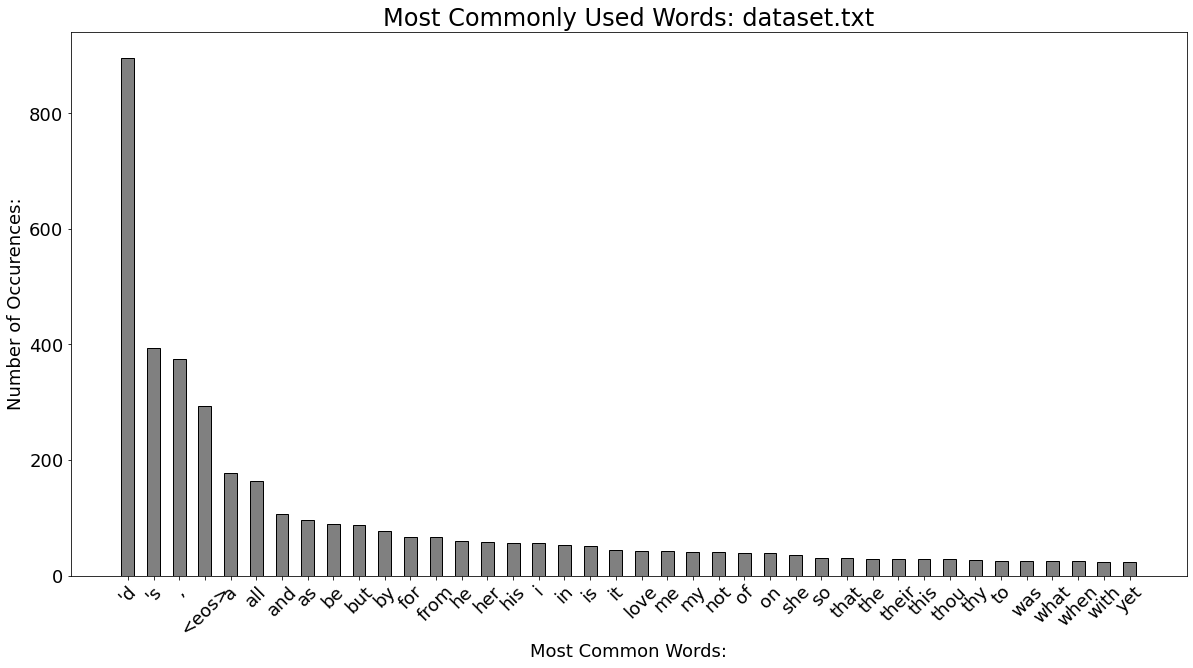

In [23]:
plotWordFrequency(artist_file)

In [24]:
import pronouncing
import markovify
import re
import random
import numpy as np
import os
import keras
from keras.models import Sequential
from keras.layers import LSTM 
from keras.layers.core import Dense

In [25]:
def create_network(depth):
	model = Sequential()
	model.add(LSTM(4, input_shape=(2, 2), return_sequences=True))
	for i in range(depth):
		model.add(LSTM(8, return_sequences=True))
	model.add(LSTM(2, return_sequences=True))
	model.summary()
	model.compile(optimizer='rmsprop',
              loss='mse')
	if artist + ".rap" in os.listdir(".") and train_mode == False:
		model.load_weights(str(artist + ".rap"))
		print("loading saved network: " + str(artist) + ".rap") 
	return model

In [26]:
def markov(text_file):
    ######
	read = open(text_file, "r", encoding='utf-8').read()
	text_model = markovify.NewlineText(read)
	return text_model

In [27]:
def syllables(line):
    count = 0
    for word in line.split("[\s|,]"):
        vowels = 'aeiou'
        word = word.lower().strip("!@#$%^&*()_+-={}[];:,.<>/?")
       # word = word.lower().strip(".:;?!")
        if word[0] in vowels:
            count +=1
        for index in range(1,len(word)):
            if word[index] in vowels and word[index-1] not in vowels:
                count +=1
        if word.endswith('e'):
            count -= 1
        if word.endswith('le'):
            count+=1
        if count == 0:
            count +=1
    return count / maxsyllables

In [28]:
def rhymeindex(lyrics):
	if str(artist) + ".rhymes" in os.listdir(".") and train_mode == False:
		print ("loading saved rhymes from " + str(artist) + ".rhymes")
		return open(str(artist) + ".rhymes", "r",encoding='utf-8').read().split("\n")
	else:
		rhyme_master_list = []
		print ("Building list of rhymes:")
		for i in lyrics:
			word = re.sub(r"\W+", '', i.split(" ")[-1]).lower()
			rhymeslist = pronouncing.rhymes(word)
			rhymeslistends = []      
			for i in rhymeslist:
				rhymeslistends.append(i[-2:])
			try:
				rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
			except Exception:
				rhymescheme = word[-2:]
			rhyme_master_list.append(rhymescheme)
		rhyme_master_list = list(set(rhyme_master_list))
		reverselist = [x[::-1] for x in rhyme_master_list]
		reverselist = sorted(reverselist)
		rhymelist = [x[::-1] for x in reverselist]
		print("List of Sorted 2-Letter Rhyme Ends:")
		print(rhymelist)
		f = open(str(artist) + ".rhymes", "w", encoding='utf-8')
		f.write("\n".join(rhymelist))
		f.close()
		return rhymelist

In [29]:
def rhyme(line, rhyme_list):
	word = re.sub(r"\W+", '', line.split(" ")[-1]).lower()
	rhymeslist = pronouncing.rhymes(word)
	rhymeslistends = []
	for i in rhymeslist:
		rhymeslistends.append(i[-2:])
	try:
		rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
	except Exception:
		rhymescheme = word[-2:]
	try:
		float_rhyme = rhyme_list.index(rhymescheme)
		float_rhyme = float_rhyme / float(len(rhyme_list))
		return float_rhyme
	except Exception:
		float_rhyme = None
		return float_rhyme

In [30]:
def split_lyrics_file(text_file):
	text = open(text_file, encoding='utf-8').read()
	text = text.split("\n")
	while "" in text:
		text.remove("")
	return text

In [31]:
def generate_lyrics(text_model, text_file):
	bars = []
	last_words = []
	lyriclength = len(open(text_file,encoding='utf-8').read().split("\n"))
	count = 0
	markov_model = markov(text_file)
	
	while len(bars) < lyriclength / 9 and count < lyriclength * 2:
		bar = markov_model.make_sentence(max_overlap_ratio = .49, tries=100)
		if type(bar) != type(None) and syllables(bar) < 1:
			def get_last_word(bar):
				last_word = bar.split(" ")[-1]
				if last_word[-1] in "!.?,":
					last_word = last_word[:-1]
				return last_word
			last_word = get_last_word(bar)
			if bar not in bars and last_words.count(last_word) < 3:
				bars.append(bar)
				last_words.append(last_word)
				count += 1
	return bars

In [32]:
def build_dataset(lines, rhyme_list):
	dataset = []
	line_list = []
	for line in lines:
		line_list = [line, syllables(line), rhyme(line, rhyme_list)]
		dataset.append(line_list)
	x_data = []
	y_data = []
	for i in range(len(dataset) - 3):
		line1 = dataset[i    ][1:]
		line2 = dataset[i + 1][1:]
		line3 = dataset[i + 2][1:]
		line4 = dataset[i + 3][1:]
		x = [line1[0], line1[1], line2[0], line2[1]]
		x = np.array(x)
		x = x.reshape(2,2)
		x_data.append(x)
		y = [line3[0], line3[1], line4[0], line4[1]]
		y = np.array(y)
		y = y.reshape(2,2)
		y_data.append(y)
	x_data = np.array(x_data)
	y_data = np.array(y_data)
	return x_data, y_data

In [33]:
def compose_rap(lines, rhyme_list, lyrics_file, model):
	rap_vectors = []
	human_lyrics = split_lyrics_file(lyrics_file)
	initial_index = random.choice(range(len(human_lyrics) - 1))
	initial_lines = human_lyrics[initial_index:initial_index + 2]
	starting_input = []
	for line in initial_lines:
		starting_input.append([syllables(line), rhyme(line, rhyme_list)])
	starting_vectors = model.predict(np.array([starting_input]).flatten().reshape(1, 2, 2))
	rap_vectors.append(starting_vectors)
	for i in range(100):
		rap_vectors.append(model.predict(np.array([rap_vectors[-1]]).flatten().reshape(1, 2, 2)))
	return rap_vectors

In [34]:
def vectors_into_song(vectors, generated_lyrics, rhyme_list):
	print ("\n\n")	
	print ("Writing verse:")
	print ("\n\n")
	def last_word_compare(rap, line2):
		penalty = 0 
		for line1 in rap:
			word1 = line1.split(" ")[-1]
			word2 = line2.split(" ")[-1]
			while word1[-1] in "?!,. ":
				word1 = word1[:-1]
			while word2[-1] in "?!,. ":
				word2 = word2[:-1]
			if word1 == word2:
				penalty += 0.2
		return penalty
	def calculate_score(vector_half, syllables, rhyme, penalty):
		desired_syllables = vector_half[0]
		desired_rhyme = vector_half[1]
		desired_syllables = desired_syllables * maxsyllables
		desired_rhyme = desired_rhyme * len(rhyme_list)
		score = 1.0 - abs(float(desired_syllables) - float(syllables)) + abs(float(desired_rhyme) - float(rhyme)) - penalty
		return score
	dataset = []
	for line in generated_lyrics:
		line_list = [line, syllables(line), rhyme(line, rhyme_list)]
		dataset.append(line_list)
	rap = []
	vector_halves = []
	for vector in vectors:
		vector_halves.append(list(vector[0][0])) 
		vector_halves.append(list(vector[0][1]))
	for vector in vector_halves:
		scorelist = []
		for item in dataset:
			line = item[0]
			if len(rap) != 0:
				penalty = last_word_compare(rap, line)
			else:
				penalty = 0
			total_score = calculate_score(vector, item[1], item[2], penalty)
			score_entry = [line, total_score]
			scorelist.append(score_entry)
		fixed_score_list = [0]
		for score in scorelist:
			fixed_score_list.append(float(score[1]))
		max_score = max(fixed_score_list)
		for item in scorelist:
			if item[1] == max_score:
				rap.append(item[0])
				print (str(item[0]))
				for i in dataset:
					if item[0] == i[0]:
						dataset.remove(i)
						break
				break     
	return rap

In [35]:
def train(x_data, y_data, model):
	model.fit(np.array(x_data), np.array(y_data),
			  batch_size=2,
			  epochs=5,
			  verbose=1)
	model.save_weights(artist + ".rap")


In [36]:
def main(depth, train_mode):
	model = create_network(depth)
	text_model = markov(text_file)
	if train_mode == True:
		bars = split_lyrics_file(text_file)
	if train_mode == False:
		bars = generate_lyrics(text_model, text_file)
	rhyme_list = rhymeindex(bars)
	if train_mode == True:
		x_data, y_data = build_dataset(bars, rhyme_list)
		train(x_data, y_data, model)
	if train_mode == False:
		vectors = compose_rap(bars, rhyme_list, text_file, model)
		rap = vectors_into_song(vectors, bars, rhyme_list)
		f = open(rap_file, "w", encoding='utf-8')
		for bar in rap:
			f.write(bar)
			f.write("\n")

In [37]:
depth = 4 
maxsyllables = 8
artist = "artist"
rap_file = "temporary_poem.txt"

In [ ]:
maxsyllables = 8
text_file = "dataset.txt"
train_mode = True        
main(depth, train_mode)
train_mode = False
main(depth, train_mode)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 2, 4)              112       
_________________________________________________________________
lstm_25 (LSTM)               (None, 2, 8)              416       
_________________________________________________________________
lstm_26 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_27 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_28 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_29 (LSTM)               (None, 2, 2)              88        
Total params: 2,248
Trainable params: 2,248
Non-trainable params: 0
____________________________________________________

In [ ]:
print(hi)